In [1]:
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

### P1: Understanding Alpha

#### P1A: Using Ridge instead of LinearRegression

In HW3, we had you fit a model to predict the x-y relationship given below.

In [2]:
p1_data = pd.read_csv("p1.csv")

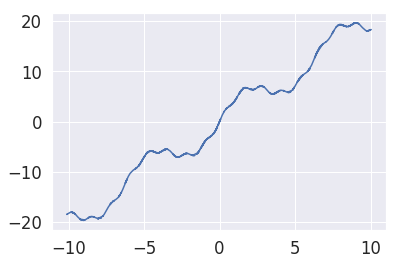

In [3]:
plt.plot(p1_data["x"], p1_data["y"])

In particular, we had you create a new dataframe with 3 features: x, sin(x) and sin(5x)

In [4]:
featurized_p1_data = pd.DataFrame({
    "phi1": p1_data["x"],
    "phi2": np.sin(p1_data["x"]),
    "phi3": np.sin(5*p1_data["x"])
})

To understand how regularization works, let's now try using the `Ridge` module instead of `LinearRegression`. Recall that `Ridge` takes an `alpha` parameter that lets us control the complexity of our model.

Let's start by using `alpha = 0`, which will make our model work exactly like `LinearRegression`.

In [5]:
p1_model_alpha0 = linear_model.Ridge(alpha = 0)
p1_model_alpha0.fit(featurized_p1_data, p1_data["y"])

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [6]:
p1_model_alpha0.coef_

array([2. , 3. , 0.5])

Observe above that the coefficients are exactly the same that we found in hw3.

Below:
1. Fit a model `p1_model_alpha100` that has an alpha value of 100. 
2. Print out the coefficients of the model and compare them to the coefficients for `p1_model`
3. Make a plot of the predictions made by `p1_model_alpha100` and compare them to the original data.

You should see that the coefficients are slightly smaller and the fit is not quite as good.

In [7]:
p1_model_alpha100 = linear_model.Ridge(alpha = 100)
p1_model_alpha100.fit(featurized_p1_data, p1_data["y"])

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [8]:
p1_model_alpha100.coef_

array([2.008366  , 2.09787207, 0.35873337])

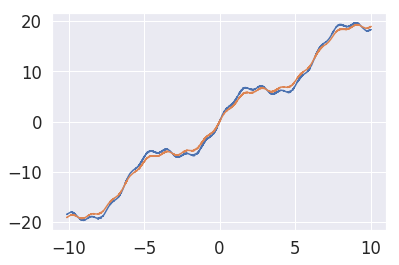

In [9]:
plt.plot(p1_data["x"], p1_data["y"])
plt.plot(p1_data["x"], p1_model_alpha100.predict(featurized_p1_data))

Now repeat the same exercise with alpha = 1000.

In [10]:
p1_model_alpha1000 = linear_model.Ridge(alpha = 1000)
p1_model_alpha1000.fit(featurized_p1_data, p1_data["y"])

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [11]:
p1_model_alpha1000.coef_

array([1.93820735, 0.59244613, 0.09695011])

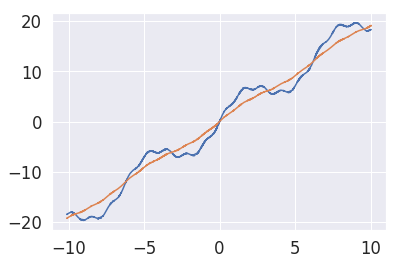

In [12]:
plt.plot(p1_data["x"], p1_data["y"])
plt.plot(p1_data["x"], p1_model_alpha1000.predict(featurized_p1_data))

You should see that the model has to spend much more of its "budget" on the linear coefficient, and isn't able to really capture much of the oscillating behavior.

#### P1B: Understanding Objective Functions

To get a better understanding for how $\alpha$ forces our parameters to be smaller, let's revisit the definition of our regularizaed model.

Recall that `Ridge` tries to minimize the sum of the mean squared error plus the squares of all the coefficients times alpha, i.e. $\text{MSE} + \alpha \sum_{i=1}^n \theta_i$.

For example, if our coefficients are `[2, 3, 0.5]`, then the MSE is effectively zero. 

In [13]:
mean_squared_error(p1_model_alpha0.predict(featurized_p1_data), p1_data["y"])

1.296757443467894e-29

If our coefficients are `[2, 3, 0.5]` and `alpha = 100`, then the objective function is $0 + 100 \times (2^2 + 3^2 + 0.5^2) = 0$

In [14]:
np.sum(100 * [2 * 2 + 3 * 3 + 0.5 * 0.5])

1325.0

Or using `p1_model_alpha0` directly:

In [15]:
np.sum(100 * p1_model_alpha0.coef_**2)

1325.0000000000011

Below, compute the value of the objective function for alpha = 100 for `p1_model_alpha100`. Hint: The result should be approximately 856.

In [16]:
mean_squared_error(p1_model_alpha100.predict(featurized_p1_data), p1_data["y"]) + np.sum(100 * p1_model_alpha100.coef_**2)

856.7143683680956

The gives us some insight into how `alpha` works. When we tell `p1_model_alpha100` to `fit` itself to the data, it has to minimize two things at once: The MSE and $\alpha \sum_{i=1}^n \theta_i$. So when faced with a choice between `[2, 3, 0.5]` and `[2, 2.1, 0.36]`, it picks `[2, 2.1, 0.36]`. Even though `[2, 2.1, 0.36]` has worse MSE, it has better $\alpha \sum_{i=1}^n \theta_i$.

Lastly, compute the value of the objective function for `p1_model_alpha1000` and `alpha = 1000`.

In [17]:
mean_squared_error(p1_model_alpha1000.predict(featurized_p1_data), p1_data["y"]) + np.sum(1000 * p1_model_alpha1000.coef_**2)

4120.209862847303

### P2: Pipelines, Scaling, Regularization

In this problem, we'll explore how to use pipelines, scaling, and regularization.

#### P2A: Understanding and Fitting Our Data

In this homework, we'll be trying to fit Seattle house prices from 2014 and 2015. I originally got this data from Kaggle (https://www.kaggle.com/harlfoxem/housesalesprediction), but did some processing to remove some errors in the data (e.g. one house was incorrectly claimed to have 33 bedrooms).

In [18]:
houses = pd.read_csv("seattle_housing.csv")

In [19]:
houses.head(5)

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


For example, the fourth house sold for 604,000 U.S. Dollars, has 3 bathrooms, and 1,960 square feet of living space (182 square meters).

We see that there are a number of different features we could use to predict the house price.

In [20]:
houses.columns

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In this problem, we will use the number of bedrooms, bathrooms, square feet of living space, square foot of the lot size, condition, and grade of the house. 

In [21]:
p2_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'condition', 'grade']


We do not take into account other important information like the part of the city in which the town is located. For example, houses near the city center are more likely to fetch a higher value. As a bonus exercise, you can try to include this additional information after completing this entier assignment.

Using what you know, fit a linear regression model called `p2_model` to the entire available dataset. 

In [22]:
p2_model = LinearRegression()

In [23]:
p2_model.fit(houses[p2_features], houses["price"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now compute the predicted price of each house:

In [24]:
price_predictions = p2_model.predict(houses[p2_features])

Below, we compute the root mean squared error (RMSE), which is just the square root of the mean squared error. If you did everything correctly, the value should be \$206,445. This means that on average, we were somewhere around \$200,000 off from the correct price in our predictions.

In the following parts of this homework, we will try to do better, while also taking care to avoid overfitting.

In [25]:
np.sqrt(mean_squared_error(price_predictions, houses["price"]))

206445.61664480748

#### P2B: Creating a Polynomial Model with Pipelines

One way that we can do better is to create new features which are polynomial combinations of our existing features. We did this in HW3.

In this problem you will do this again, but now using sklearn pipelines.

Using the lecture code as a guide, create and fit a model called `p2_poly2_model`. It should have two stages, the first of which is `PolynomialFeatures`, and the second of which is `LinearRegression`. Use a degree of 2 for your polynomial.

Hint: See `diamond_poly_model` in the notebook for lecture 4.

In [26]:
p2_poly2_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression(fit_intercept=False))
])
p2_poly2_model.fit(houses[p2_features], houses["price"])

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False))])

Below, we compute price predictions and compute the RMSE for those predictions. 

In [27]:
poly2_price_predictions = p2_poly2_model.predict(houses[p2_features])

In [28]:
np.sqrt(mean_squared_error(poly2_price_predictions, houses["price"]))

189062.53010330888

Observe that the error is now lower. By creating new features, we now get better predictions.

Below, repeat the same exercise but with a degree of 3. 

In [29]:
p2_poly3_model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('model', LinearRegression(fit_intercept=False))
])
p2_poly3_model.fit(houses[p2_features], houses["price"])

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False))])

In [30]:
poly3_price_predictions = p2_poly3_model.predict(houses[p2_features])

In [31]:
np.sqrt(mean_squared_error(poly3_price_predictions, houses["price"]))

261582.41606486545

Above, you should find that the RMSE for a degree 3 model is more than \$260,000. That is, by adding additional features to use in fitting our model, we have somehow made our model worse.

In theory, adding new features should never make our Linear Regression models worse (there are interesting mathematical reasons we have not covered in our course). However, our RMSE has gotten much worse!

The reason is that the degree 3 polynomial results in values that are so large that your computer cannot store them precisely (see https://en.wikipedia.org/wiki/Round-off_error if you're curious).

For example, the line below shows that one of our features is on the order of 10 to the 18th power. 

In [32]:
np.max(p2_poly3_model.named_steps["poly"].transform(houses[p2_features]))

1.0739557477092424e+18

In the next section, we'll see how to avoid this problem.

#### P2C: Using the StandardScaler

By rescaling the units of our original data so that each has mean 0 and variance 1, we can avoid the numerical precision errors we faced earlier.

In [33]:
from sklearn.preprocessing import StandardScaler

Using the lecture code as a guide, create and fit a model called `p2_scaled_poly2_model`. It should have three stages, the first of which is `StandardScaler`, the second of which is `PolynomialFeatures`, and the third of which is `LinearRegression`. Use a degree of 2 for your polynomial.

Hint: See `degree_4_linear_regression_model` from the lecture notebook for an example.

In [34]:
p2_scaled_poly2_model = Pipeline([        
    ('scale', StandardScaler()),        
    ('poly', PolynomialFeatures(degree=2)),
    ('model', linear_model.LinearRegression(fit_intercept=False))
])   
p2_scaled_poly2_model.fit(houses[p2_features], houses["price"])

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False))])

Below we compute predictions for your model, followed by the RMSE. If you did this right, the RMSE should be around \$190,000.

In [35]:
scaled_poly2_price_predictions = p2_scaled_poly2_model.predict(houses[p2_features])

In [36]:
np.sqrt(mean_squared_error(scaled_poly2_price_predictions, houses["price"]))

189062.53010330818

Note that your `p2_poly2_model` from problem p2b also had an RMSE of approximately \$190,000. In other words, scaling didn't help for the degree 2 model.

However, we'll see that it helps a lot with a degree 3 polynomial. Below, create a model `p2_scaled_poly3_model` that is exactly the same as `p2_scaled_poly2_model`, but with degree 3.

In [37]:
p2_scaled_poly3_model = Pipeline([        
    ('scale', StandardScaler()),        
    ('poly', PolynomialFeatures(degree=3)),
    ('model', linear_model.LinearRegression(fit_intercept=False))
])   
p2_scaled_poly3_model.fit(houses[p2_features], houses["price"])

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False))])

Below, compute the RMSE for `p2_scaled_poly3_model`. You should get a value of approximately \$185,000.

This is much better than `p2_poly3_model`, which had had RMSE of approximately \$260,000.

Here, scaling made an enormous difference.

In [38]:
scaled_poly3_price_predictions = p2_scaled_poly3_model.predict(houses[p2_features])

In [39]:
np.sqrt(mean_squared_error(scaled_poly3_price_predictions, houses["price"]))

185358.45105851037

#### P2D: Visualizing RMSE vs. Degree

Similar to what we did part 2D of homework 3, we will create a plot of the RMSE vs. polynomial degree.

First, we will split our data into a training, validation, and test set.

We use `np.split` to create `house_training_data`, `house_validation_data`, and `house_test_data` with 16209, 2702, and 2702 data points, respectively.

I picked these numbers so that the training set was 75% of the data, and the test and validation sets made up the remaining 25%.

In [40]:
len(houses)

21456

In [41]:
N_train = 16092
N_validation = 16209 + 2682

In [42]:
house_training_data, house_validation_data, house_test_data = np.split(houses, [N_train, N_validation])

In [43]:
house_training_data_og = house_training_data.copy()

Fill in the function `get_training_and_validation_rmse(degree)` so that it returns the RMSE for the training and validation sets for a model with the given polynomial degree.

For example, `get_training_and_validation_rmse(4)` should return approximately `(181,000, 195,000)`.

Your solution should look quite similar to problem 2d from the lecture 3 homework.

In [44]:
def get_training_and_validation_rmse(degree):
    model = Pipeline([        
        ('scale', StandardScaler()),                
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', linear_model.LinearRegression(fit_intercept=False))
    ])   
    
    model.fit(house_training_data[p2_features], house_training_data["price"])
    
    training_predictions = model.predict(house_training_data[p2_features])
    training_rmse = np.sqrt(mean_squared_error(training_predictions, house_training_data["price"]))
    
    validation_predictions = model.predict(house_validation_data[p2_features])
    validation_rmse = np.sqrt(mean_squared_error(validation_predictions, house_validation_data["price"]))
    return training_rmse, validation_rmse

In [45]:
get_training_and_validation_rmse(1)

(206718.11190302964, 207882.6838279295)

In [46]:
get_training_and_validation_rmse(2)

(189350.78040621636, 190324.26499855894)

In [47]:
get_training_and_validation_rmse(3)

(184863.82777276833, 190106.75690551547)

In [48]:
get_training_and_validation_rmse(4)

(181308.00074052493, 194575.13286059108)

Below, create a plot of the training and validation RMSE vs. the degree. For reference, feel free to look back at the code in the lecture 3 homework.

In [49]:
rmses = np.array([get_training_and_validation_rmse(i) for i in range(6)])

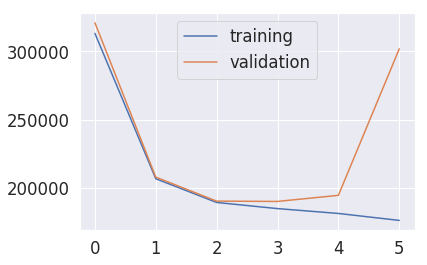

In [50]:
plt.plot(rmses[:, 0])
plt.plot(rmses[:, 1])
plt.legend(["training", "validation"])

Above, you should see that the training error goes down and down as the polynomial degree increases. However, the validation error starts going up at degree 3, and increases dramatically at degree 5.

This means that we are severely overfitting once we hit degree 5.

In the next problem, we'll see how we can use regularization to keep all the degree 5 features, but still avoid overfitting.

#### P2E: Using the Validation Set to Select an Alpha

Below, create a function `get_regularized_training_and_validation_rmse(alpha)` that is exactly the same as `get_training_and_validation_rmse(degree)`, except that:

1. It should take a parameter called `alpha` instead of `degree`.
2. The pipeline should use a `PolynomialFeatures` with degree 5.
3. It should use `linear_model.Ridge` instead of `linear_model.LinearRegression`. The alpha parameter for this Ridge model should be equal to the given parameter.

In [68]:
def get_regularized_training_and_validation_rmse(alpha):
    model = Pipeline([        
        ('scale', StandardScaler()),        
        ('poly', PolynomialFeatures(degree=5)),
        ('model', linear_model.Ridge(fit_intercept=False, alpha = alpha))
    ])   
    model.fit(house_training_data[p2_features], house_training_data["price"])
    
    training_predictions = model.predict(house_training_data[p2_features])
    training_rmse = np.sqrt(mean_squared_error(training_predictions, house_training_data["price"]))
    
    validation_predictions = model.predict(house_validation_data[p2_features])
    validation_rmse = np.sqrt(mean_squared_error(validation_predictions, house_validation_data["price"]))
    return training_rmse, validation_rmse

The code below will plot the training and validation RMSE for various alphas using your function. It will take a while to run, possibly a few minutes.

If it's taking too long, change the 50 to a small number.

In [69]:
alphas = 10**np.linspace(0, 8, 50)

In [70]:
rmses = np.array([get_regularized_training_and_validation_rmse(alpha) for alpha in alphas])

Text(0, 0.5, 'RMSE')

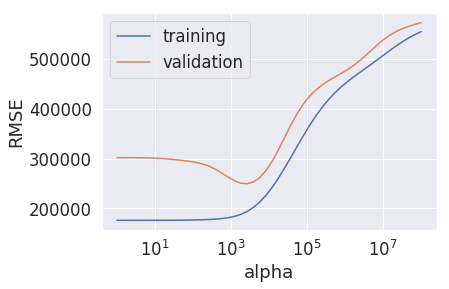

In [71]:
plt.semilogx(alphas, rmses[:, 0])
plt.semilogx(alphas, rmses[:, 1])
plt.legend(["training", "validation"])
plt.xlabel('alpha')
plt.ylabel('RMSE')

In [72]:
#You can use the code below to find the index of the minimum validation error
#np.where(rmses[:, 1] == min(rmses[:, 1]))

(array([21]),)

In [73]:
alphas[21]

2682.6957952797247

Some questions to ponder:

1. What is the best alpha to choose?
2. Are the models with large alpha (right side of the graph) high complexity or low complexity?
3. What part of the plot shows overfitting?

#### P2F:  Performance on the Test Set

Based on your plot from problem P2E, train a model called `p2f_model` with the optimal alpha on `house_training_data`, then compute the RMSE on the test set in `house_test_data`.

Your result should be less than \$210,000.

In [74]:
p2f_model = Pipeline([        
    ('scale', StandardScaler()),        
    ('poly', PolynomialFeatures(degree=5)),
    ('model', linear_model.Ridge(fit_intercept=False, alpha = 2500.0))
])   
p2f_model.fit(house_training_data[p2_features], house_training_data["price"])

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)), ('model', Ridge(alpha=2500.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [75]:
np.sqrt(mean_squared_error(p2f_model.predict(house_test_data[p2_features]), house_test_data["price"]))

204324.37625072524

**Very important:** We managed to achieve this level of error without ever using the test data in any way. You'll see it's roughly as good as we got on the training set. Not bad! We have confidence that our model should generalize to other data from the same distribution. That is, if we pick a Seattle house at random from 2015, we would expect to get RMSE of less than \$210,000. 

In theory, we could try adjusting the alpha to get better test error. In practice, this would be an incredibly bad idea. In effect, we would be fitting our alpha to the test data. Since the goal of our model is to build something that will work for future prediction, we would have no confidence it would work in the real world.

*Note:* An RMSE of \$210,000 is much better than random guessing, but there is still a lot more work to do to get the error lower. Taking into things like the neighborhood a house belongs to would help a lot. We leave this as an exercise for the especially interested student.

#### P2G: Using RidgeCV

In problem P2F, we found the optimal alpha by using a plot of the error on a validation set.

An alternate approach is to use `RidgeCV`, which will automatically find the optimal `alpha` using only the validation set.

Create a model `p2g_model` that uses `RidgeCV`. For the alphas parameter, use `10**np.linspace(0, 8, 50)`.

This will probably take a while to run, possibly several minutes.

In [58]:
p2g_model = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=5)),
    ('model', linear_model.RidgeCV(alphas=10**np.linspace(0, 8, 50),  fit_intercept=False))
])    
p2g_model.fit(house_training_data[p2_features], house_training_data[["price"]])

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)), ('model', RidgeCV(alphas=array([1.00000e+00, 1.45635e+00, 2.12095e+00, 3.08884e+00, 4.49843e+00,
       6.55129e+00, 9.54095e+00, 1.38950e+01...one, fit_intercept=False, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False))])

In [59]:
p2g_model.named_steps['model'].alpha_

281.1768697974228

Above, we see that RidgeCV picks an alpha that is not the same as the one that you picked using a validation set.

Below, we can evaluate the performance of the resulting model. You should see that the RMSE is pretty close to what you got in problem p2f.

In [60]:
np.sqrt(mean_squared_error(p2g_model.predict(house_test_data[p2_features]), house_test_data["price"]))

199507.97946411234

**Important note:** `RidgeCV` was able to select a good alpha without using a special validation set. That is, it picked the alpha using ONLY the traiining set.

The technique that `RidgeCV` uses is called "cross validation", and is described in lecture 4. We will not discuss the details of cross validation further in this homework.

**Caveat:** There is a subtle issue with the way we used RidgeCV. In particular, the StandardScaler scales all of the data before passing it to RidgeCV. Ideally, we'd separately scale the data for each cross validation fold. This is a pretty advanced topic, so we will not discuss this in our course.

**Takeaway:** In real world projects, you're welcome to use the approach from `p2f_model` or from `p2g_model`.

p2f_model: Set aside a special validation set and test set. Use training set to fit the parameters of your ridge model. Use the validation set to fit the hyperparameters (in this case, alpha). Use the test set to evaluate performance at the very end. 

p2g_model: Set aside a special test set. Use the cross-validation technique to fit the parameters and hyperparamters using the training data. Use the test set to evalute performance at the very end.

Both approaches are valid, but the p2g_model style is more common in the real world.

**One last warning:** It is very important to avoid using the test data in any way whatsoever! You should not use the test data to fit paramters or hyperparamters.

#### Bonus Problem P2H: Lasso

Recall from lecture that there is an alternate to Ridge regression called LASSO regression. The difference in outcome is that LASSO models have many zero paramters.

Let's see it in action. Note that LASSO models are generally more numerically difficult to fit, so you may see several warnings appear about convergence. 

In [61]:
p2h_model = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=5)),
    ('model', linear_model.LassoCV(alphas=10**np.linspace(0, 8, 50),  fit_intercept=False))
])    
p2h_model.fit(house_training_data[p2_features], house_training_data[["price"]])

/home/hug/miniconda2/envs/data100/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hug/miniconda2/envs/data100/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/hug/miniconda2/envs/data100/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)), ('model', LassoCV(alphas=array([1.00000e+00, 1.45635e+00, 2.12095e+00, 3.08884e+00, 4.49843e+00,
       6.55129e+00, 9.54095e+00, 1.38950e+01...alse,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

You'll see the RMSE of the resulting LASSO model is similar to the RidgeCV RMSE from problem p2g.

In [62]:
np.sqrt(mean_squared_error(p2h_model.predict(house_test_data[p2_features]), house_test_data["price"]))

189661.15862046467

The big difference is that the coefficents of the p2h_model are almost all zero, whereas with p2g_model, none of them are.

In [63]:
p2g_model.named_steps['model'].coef_

array([[ 3.38831354e+05, -6.92128440e+03, -1.65541976e+04,
         8.04259986e+04, -5.39149050e+04, -1.14373719e+04,
         8.81106576e+04,  3.30468073e+04, -2.35601253e+03,
        -1.09725110e+04,  8.49679646e+03,  1.20384165e+03,
         1.21124360e+03,  3.64975524e+04, -7.84778196e+03,
         1.44098545e+04,  2.24101680e+04, -1.01119811e+04,
         1.93569597e+04, -1.59922456e+04,  8.70344034e+03,
         2.97385684e+03,  5.91291504e+04, -1.43121329e+04,
        -2.59796632e+04,  1.55010980e+05,  9.33354091e+03,
         4.37937773e+04, -3.05740069e+03, -1.46131095e+03,
         1.39024271e+03, -2.49638129e+03, -1.41827137e+03,
         1.46637831e+04, -2.32044133e+03, -1.35316201e+04,
         4.81214009e+03,  2.60289511e+03, -1.33664595e+03,
         8.06319793e+03,  1.35002374e+04, -8.06395204e+03,
        -1.50453762e+04,  5.61425803e+03, -6.23530008e+03,
         8.24064989e+03, -1.63351136e+04,  3.74596324e+03,
         1.23540444e+04, -4.55031140e+02,  4.85531734e+0

In [64]:
p2h_model.named_steps['model'].coef_

array([ 4.53576618e+05, -0.00000000e+00,  0.00000000e+00,  7.07149201e+04,
       -0.00000000e+00,  4.97772289e+03,  9.01448762e+04,  6.98872719e+03,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.21285916e+04,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.82085213e+03, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.18191210e+04,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

To understand what features each coefficient corresponds to, we can use the `get_feature_names` function of the `PolynomialFeatures` object.

In [65]:
pf = PolynomialFeatures(degree=5)
pf.fit(house_training_data[p2_features])
feature_names = pf.get_feature_names(p2_features)
feature_names

/home/hug/miniconda2/envs/data100/lib/python3.6/site-packages/sklearn/preprocessing/data.py:1263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for c in combinations)


['1',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'condition',
 'grade',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms sqft_living',
 'bedrooms sqft_lot',
 'bedrooms condition',
 'bedrooms grade',
 'bathrooms^2',
 'bathrooms sqft_living',
 'bathrooms sqft_lot',
 'bathrooms condition',
 'bathrooms grade',
 'sqft_living^2',
 'sqft_living sqft_lot',
 'sqft_living condition',
 'sqft_living grade',
 'sqft_lot^2',
 'sqft_lot condition',
 'sqft_lot grade',
 'condition^2',
 'condition grade',
 'grade^2',
 'bedrooms^3',
 'bedrooms^2 bathrooms',
 'bedrooms^2 sqft_living',
 'bedrooms^2 sqft_lot',
 'bedrooms^2 condition',
 'bedrooms^2 grade',
 'bedrooms bathrooms^2',
 'bedrooms bathrooms sqft_living',
 'bedrooms bathrooms sqft_lot',
 'bedrooms bathrooms condition',
 'bedrooms bathrooms grade',
 'bedrooms sqft_living^2',
 'bedrooms sqft_living sqft_lot',
 'bedrooms sqft_living condition',
 'bedrooms sqft_living grade',
 'bedrooms sqft_lot^2',
 'bedrooms sqft_lot condition',
 'bedroo

For example, the first coefficient is approximately \$453,000, which is the intercept term for our model.

The second and third coefficients are 0, which correspond to the weight of our "bedrooms" feature and "bathrooms" feature. 

Challenge: Create a table of all the features and their weights. Only include features with non-zero weight.

In [66]:
feature_table = pd.DataFrame({'name': feature_names, 'weight': p2h_model.named_steps['model'].coef_})
feature_table.head(10)

,name,weight
0,1,453576.617822
1,bedrooms,-0.000000
2,bathrooms,0.000000
3,sqft_living,70714.920065
4,sqft_lot,-0.000000
5,condition,4977.722890
6,grade,90144.876211
7,bedrooms^2,6988.727188
8,bedrooms bathrooms,0.000000
9,bedrooms sqft_living,0.000000


In [67]:
feature_table[abs(feature_table["weight"]) > 10**-2].sort_values("weight", ascending = False)

,name,weight
0,1,453576.617822
6,grade,90144.876211
3,sqft_living,70714.920065
27,grade^2,21819.120976
13,bathrooms^2,12128.591597
...,...,...
201,sqft_lot condition^3,-1052.785978
419,sqft_living^2 sqft_lot condition^2,-1141.980869
454,sqft_lot condition grade^3,-1268.756693
204,sqft_lot grade^3,-2518.116798
